## Downloading and Unziping Data

In [1]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2026-01-18 05:47:15--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.222.206.35, 2600:1406:bc00:196::317f, 2600:1406:bc00:18b::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.222.206.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M  99.5MB/s    in 7.7s    

2026-01-18 05:47:23 (102 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [2]:
!unzip -q kagglecatsanddogs_5340.zip

## Importing Modules

In [3]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tqdm
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')

## Creating Dataframe for Input and Output

In [4]:
input_path = []
label = []

for class_name in os.listdir('PetImages'):
  for path in os.listdir("PetImages/"+class_name):
    if class_name == "Cat":
      label.append(0)
    else:
      label.append(1)
    input_path.append(os.path.join("PetImages",class_name,path))
print(input_path[0],label[0])

PetImages/Dog/1389.jpg 1


In [5]:
df = pd.DataFrame({
    'images':input_path,
    'label':label
})
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,images,label
0,PetImages/Cat/10651.jpg,0
1,PetImages/Dog/1724.jpg,1
2,PetImages/Dog/10931.jpg,1
3,PetImages/Dog/8125.jpg,1
4,PetImages/Cat/4395.jpg,0


In [6]:
df['label'] = df['label'].astype('str')

## Exploratory Data Analysis

In [7]:
plt.figure(figsize =(25,25))
temp = df[df['label'] == 1]['images']
start = random.randint(0,len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
  plt.subplot(5,5,index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('Dog')
  plt.axis('off')

<Figure size 2500x2500 with 0 Axes>

In [8]:
plt.figure(figsize =(25,25))
temp = df[df['label'] == 0]['images']
start = random.randint(0,len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
  plt.subplot(5,5,index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('Cat')
  plt.axis('off')

<Figure size 2500x2500 with 0 Axes>

In [9]:
df['label'].value_counts()

,count
label,
0,12501
1,12501


## Creating DataGenerator for Images

In [10]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size=0.2,random_state=42)

In [11]:
test_df.head()

,images,label
9254,PetImages/Dog/3110.jpg,1
8049,PetImages/Cat/473.jpg,0
23757,PetImages/Cat/11563.jpg,0
3463,PetImages/Dog/430.jpg,1
20539,PetImages/Dog/10280.jpg,1


In [30]:
def clean_dataframe(df, img_col, label_col):
    clean_rows = []

    for _, row in df.iterrows():
        path = row[img_col]

        try:
            # extension check
            if not path.lower().endswith(('.jpg', '.jpeg')):
                continue

            # existence check
            if not os.path.exists(path):
                continue

            # image validity check
            img = Image.open(path)
            img.verify()

            clean_rows.append(row)

        except:
            continue

    clean_df = pd.DataFrame(clean_rows).reset_index(drop=True)
    print(f"Cleaned: {len(df)} → {len(clean_df)}")
    return clean_df


In [31]:
train_df = clean_dataframe(train_df, 'images', 'label')
test_df  = clean_dataframe(test_df, 'images', 'label')


Cleaned: 20001 → 19998
Cleaned: 5001 → 5000


In [32]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_generator = ImageDataGenerator(rescale=1./255)


In [33]:
BATCH_SIZE = 32

train_iterator = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    validate_filenames=True
)

val_iterator = val_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    validate_filenames=True
)


Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## Model Creation

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])



In [43]:
import tensorflow as tf
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,529 (494.25 KB)

 Trainable params: 126,529 (494.25 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)


In [45]:
history = model.fit(
    train_iterator,
    epochs=50,
    validation_data=val_iterator,
    callbacks=[early_stop, lr_reduce],
    verbose=1
)


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 192ms/step - accuracy: 0.5413 - loss: 0.6822 - val_accuracy: 0.6294 - val_loss: 0.6386 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 116s 185ms/step - accuracy: 0.6431 - loss: 0.6347 - val_accuracy: 0.6802 - val_loss: 0.6004 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 115s 183ms/step - accuracy: 0.6740 - loss: 0.6048 - val_accuracy: 0.7120 - val_loss: 0.5682 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 115s 183ms/step - accuracy: 0.6848 - loss: 0.5901 - val_accuracy: 0.6982 - val_loss: 0.5741 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 118s 189ms/step - accuracy: 0.6955 - loss: 0.5794 - val_accuracy: 0.7238 - val_loss: 0.5375 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 116s 185ms/step - accuracy: 0.7140 - loss: 0.5555 - val_accuracy: 0.7036 - val_loss: 0.5674 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 116s 186ms/step - accura

## Validation Graphs

In [46]:
# History object from model.fit
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

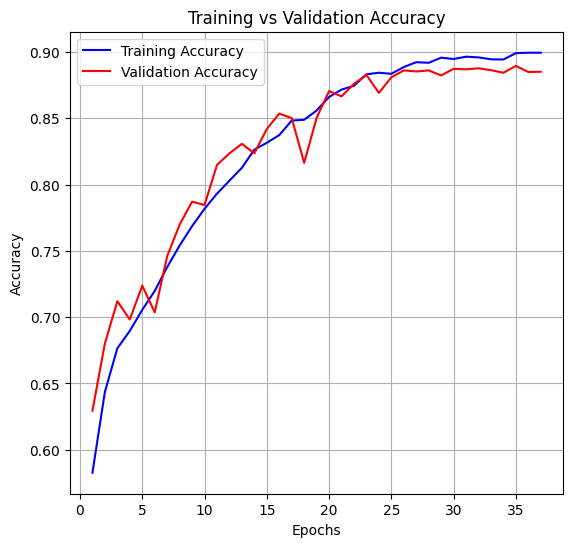

In [47]:
plt.figure(figsize=(14,6))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

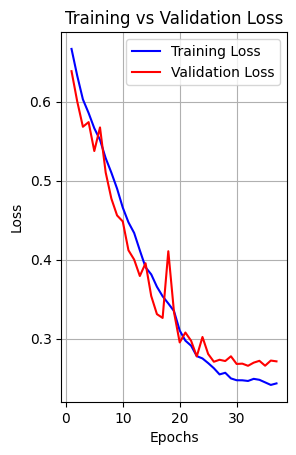

In [48]:
# Loss plot
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

## Testing


In [50]:
test_gen = ImageDataGenerator(rescale=1./255)

test_iterator = test_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False,        # important: keep original order
    validate_filenames=True
)


Found 5000 validated image filenames belonging to 2 classes.


In [51]:
test_loss, test_acc = model.evaluate(test_iterator, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.8910 - loss: 0.2598
Test Accuracy: 0.8878, Test Loss: 0.2657


## Real Life Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
This is a DOG! (Confidence: 0.9901)


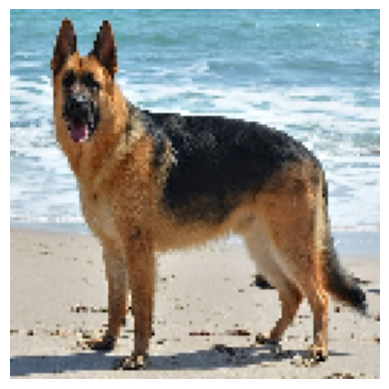

In [53]:
from tensorflow.keras.preprocessing import image

img_path = "/content/German_Shepherd_-_DSC_0346_(10096362833).jpg"  # Replace with your file path

img = image.load_img(img_path, target_size=(128,128))   # Resize to model input
img_array = image.img_to_array(img)                     # Convert to array
img_array = img_array / 255.0                           # Rescale like training
img_array = np.expand_dims(img_array, axis=0)           # Add batch dimension

prediction = model.predict(img_array)[0][0]

# Prediction
if prediction > 0.5:
    print(f"This is a DOG! (Confidence: {prediction:.4f})")
else:
    print(f"This is a CAT! (Confidence: {1-prediction:.4f})")
# Result
plt.imshow(img)
plt.axis('off')
plt.show()


## .h5 File

In [54]:
model.save('cat_dog_model.h5')


Enter path to image: /content/German_Shepherd_-_DSC_0346_(10096362833).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
This is a DOG! (Confidence: 0.9901)


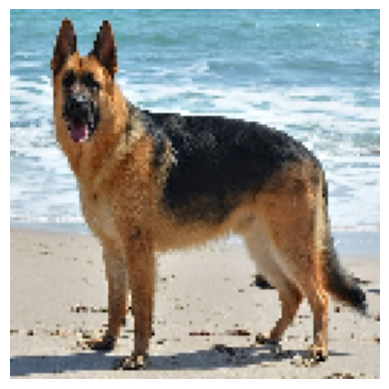

In [55]:
# Load the trained model
model = tf.keras.models.load_model('cat_dog_model.h5')

# Function to predict a single image
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(128,128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)[0][0]

    if pred > 0.5:
        label = "DOG"
        confidence = pred
    else:
        label = "CAT"
        confidence = 1 - pred

    print(f"This is a {label}! (Confidence: {confidence:.4f})")

    plt.imshow(img)
    plt.axis('off')
    plt.show()


img_path = input("Enter path to image: ")
predict_image(img_path)


In [56]:
from google.colab import files
files.download('cat_dog_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
from google.colab import files
import tensorflow as tf

# Upload the saved .h5 file
uploaded = files.upload()  # Select cat_dog_model.h5 from your PC

# Load the model
model = tf.keras.models.load_model('cat_dog_model.h5')
print("Model loaded successfully!")


Saving cat_dog_model.h5 to cat_dog_model (1).h5
Model loaded successfully!


Enter path to image: /content/German_Shepherd_-_DSC_0346_(10096362833).jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
This is a DOG! (Confidence: 0.9901)


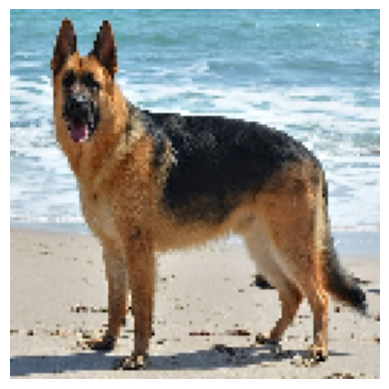

In [60]:
path = input("Enter path to image: ")
predict_image(path)